In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Network

## Session 10

## FIFA dataset 

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import tensorflow as tf

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

2024-05-23 17:46:56.633900: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 17:46:56.633940: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 17:46:56.634884: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-23 17:46:56.639933: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 17:46:57.398011: W tensorflow/compiler/tf2

In [3]:
print (fn_plot_tf_hist.__doc__)


    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    


In [4]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [5]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input'
outDir = '../output'
modelDir = '../models'
subDir = 'fifa_2019'
logDir = '../logs'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 1000 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
REG_LAMBDA = 0.001

PATIENCE = 20
LR_PATIENCE  = 10
LR_FACTOR = 0.1

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [6]:
# # Check if all directories are present
# if not os.path.exists(os.path.join(outDir)):
#     os.makedirs(os.path.join(outDir))
#     print ('Created {} directory'.format(outDir))

# if not os.path.exists(os.path.join(modelDir, subDir)):
#     os.makedirs(os.path.join(modelDir, subDir))
#     print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## Read FIFA 2019 data set

In [7]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [8]:
#data_df.head()

In [9]:
# for col in data_df.columns:
#     print (f'{col}: {data_df[col].unique()}')

In [10]:
# data_df.describe().T

In [11]:
#data_df[data_df['Position'].isnull()]

In [12]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [13]:
# Following columns appear to be relevant for our analysis
rel_cols = ['Position', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [14]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [15]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], 
                                    downcast="integer")

In [16]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [17]:
labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [18]:
features_df = data_df.drop('Position', axis =1)
labels = data_df['Position']

In [19]:
# splitting in train ans test datasets
X_train, X_test, y_train, y_test = train_test_split(features_df,
                                                    labels,
                                     stratify=labels,
                                     test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14517, 33), (3630, 33), (14517,), (3630,))

In [20]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)


In [21]:
X_train.shape

(14517, 33)

In [22]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()


In [23]:
# 33-> 23 ->12->4->4

In [24]:
k_init = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

# k_reg = tf.keras.regularizers.L2(l2=REG_LAMBDA)
k_reg = None

###--------------
### Dropout Rates
###--------------
dor1 =0.05
dor2 =0.10
dor3 =0.20
dor4 =0.20


model =  tf.keras.Sequential([
    ###------------
    ### Input Layer
    ###------------
    tf.keras.layers.InputLayer(input_shape = (33,)),

    ###------
    ### Set 1
    ###------
    tf.keras.layers.Dense(33, 
                          # activation= 'relu', 
                          kernel_initializer = k_init, 
                          kernel_regularizer= k_reg),
    # BN Layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    # Do Layer
    #tf.keras.layers.Dropout(dor1),

    ###------
    ### Set 2
    ###------
    tf.keras.layers.Dense(23, 
                          #activation= 'relu', 
                          kernel_initializer = k_init, 
                          kernel_regularizer= k_reg),
    # BN Layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    # Do Layer
    #tf.keras.layers.Dropout(dor2),

    ###------                
    ### Set 3
    ###------
    tf.keras.layers.Dense(12, 
                          #activation= 'relu', 
                          kernel_initializer = k_init, 
                          kernel_regularizer= k_reg),
    # BN Layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    # Do Layer
    #tf.keras.layers.Dropout(dor3),

    ###------
    ### Set 4
    ###------
    tf.keras.layers.Dense(4, 
                          #activation= 'relu', 
                          kernel_initializer = k_init, 
                          kernel_regularizer= k_reg),
    # BN Layer
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    # Do Layer
    #tf.keras.layers.Dropout(dor4),

    # Output layer
    tf.keras.layers.Dense(4)
])

2024-05-23 17:46:58.438581: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-23 17:46:58.475782: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-23 17:46:58.476017: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Callbacks

In [25]:
checkpoint_filepath = os.path.join(modelDir, subDir, 'weights_fifa')

model_ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = 'val_loss',
    mode = 'auto',
    verbose=2,
    save_best_only = True)


es_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience=PATIENCE,
    mode='auto',
    verbose=2,
    restore_best_weights=True)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=2,
    mode='auto',
    min_lr=0.00001)

log_dir = os.path.join(logDir, 'fit')
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [26]:
model(X_train[:1])

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.05435826,  0.03226722,  0.22121209, -0.03563111]],
      dtype=float32)>

In [27]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True)

optimizer = tf.keras.optimizers.Adam(learning_rate=ALPHA)

In [28]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                    callbacks=[model_ckpt_callback, 
                               es_callback,
                               lr_callback,
                               tb_callback],
                    verbose=2)

Epoch 1/1000


2024-05-23 17:47:00.468317: I external/local_xla/xla/service/service.cc:168] XLA service 0x774e8b903470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-23 17:47:00.468350: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-05-23 17:47:00.473113: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-23 17:47:00.487477: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1716466620.558176   49990 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 0.46361, saving model to ../models/fifa_2019/weights_fifa
454/454 - 4s - loss: 0.7825 - accuracy: 0.7384 - val_loss: 0.4636 - val_accuracy: 0.8556 - lr: 0.0010 - 4s/epoch - 9ms/step
Epoch 2/1000

Epoch 2: val_loss improved from 0.46361 to 0.34221, saving model to ../models/fifa_2019/weights_fifa
454/454 - 2s - loss: 0.4223 - accuracy: 0.8532 - val_loss: 0.3422 - val_accuracy: 0.8664 - lr: 0.0010 - 2s/epoch - 4ms/step
Epoch 3/1000

Epoch 3: val_loss improved from 0.34221 to 0.32322, saving model to ../models/fifa_2019/weights_fifa
454/454 - 2s - loss: 0.3613 - accuracy: 0.8621 - val_loss: 0.3232 - val_accuracy: 0.8672 - lr: 0.0010 - 2s/epoch - 4ms/step
Epoch 4/1000

Epoch 4: val_loss improved from 0.32322 to 0.31934, saving model to ../models/fifa_2019/weights_fifa
454/454 - 2s - loss: 0.3368 - accuracy: 0.8668 - val_loss: 0.3193 - val_accuracy: 0.8639 - lr: 0.0010 - 2s/epoch - 4ms/step
Epoch 5/1000

Epoch 5: val_loss improved from 0.31934 to 0.31

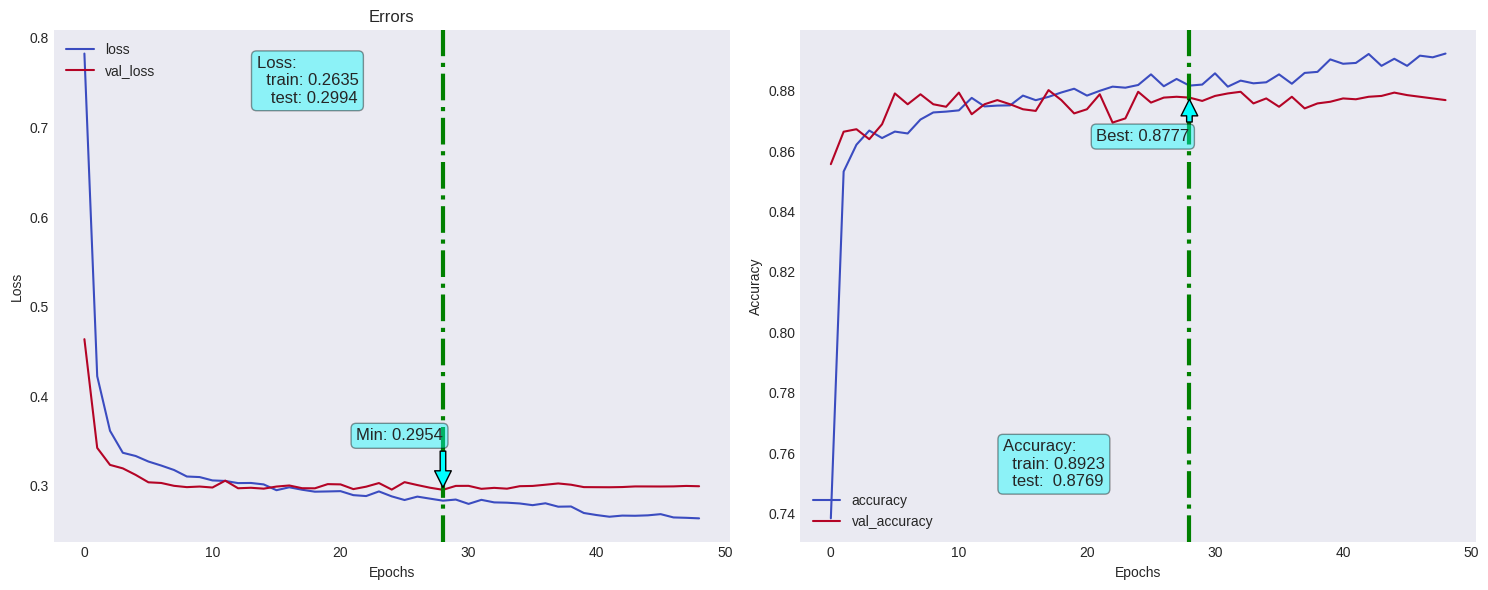

In [29]:
fn_plot_tf_hist(pd.DataFrame(history.history))

In [30]:
model.evaluate(X_test, y_test)

114/114 [==============================] - 0s 2ms/step - loss: 0.2954 - accuracy: 0.8777


[0.29541581869125366, 0.8776859641075134]